<img class='pull-right' src='Images/ISFOG_logo_edited.png' width=150>

# ISFOG 2020 - Pile driving prediction event

Data science techniques are rapidly transforming businesses in a broad range of sectors. While marketing and social applications have received most attention to date, geotechnical engineering can also benefit from data science tools that are now readily available. 

In the context of the ISFOG2020 conference in Austin, TX, a prediction event is launched which invites geotechnical engineers to share knowledge and gain hands-on experience with machine learning models.

This Jupyter notebook shows you how to get started with machine learning (ML) tools and creates a simple ML model for pile driveability. Participants are encouraged to work through this initial notebook to get familiar with the dataset and the basics of ML.

## 1. Importing package

The Python programming language works with a number of packages. We will work with the ```Pandas``` package for data processing, ```Matplotlib``` for data visualisation and ```scikit-learn``` for the ML. We will also make use of the numerical package ```Numpy```. These package come pre-installed with the Anaconda distribution (see installation guide). Each package is extensively documented with online documentation, tutorials and examples. We can import the necessary packages with the following code.

<b>Note</b>: Code cells can be executed with <i>Shift+Enter</i> or by using the run button in the toolbar at the top. Note that code cells need to be executed from top to bottom. The order of execution is important.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

We will display charts in the notebook. To accomplish this, we need one more code statement:

In [2]:
%matplotlib inline

## 2. Pile driving data

The dataset is kindly provided by [Cathie Group](http://www.cathiegroup.com).

### 2.1. Importing data

The first step in any data science exercise is to get familiar with the data. The data is provided in a csv file (```training_data.csv```). We can import the data with Pandas and display the first five rows using the ```head()``` function.

In [3]:
data = pd.read_csv("Data/training_data.csv")  # Store the contents of the csv file in the variable 'data'
data.head()

,z [m],qc [MPa],fs [MPa],u2 [MPa],ID,Location ID,Blowcount [Blows/m],Normalised ENTRHU [-],Normalised hammer energy [-],Number of blows,Diameter [m],Bottom wall thickness [mm],Pile penetration [m]
0,0.5,5.150400,0.031200,0.006400,EK__0_5,EK,NaN,NaN,NaN,NaN,2.48,50.0,31.0
1,1.0,11.681000,0.082700,0.015400,EK__1_0,EK,NaN,NaN,NaN,NaN,2.48,50.0,31.0
2,1.5,11.107600,0.101300,0.019100,EK__1_5,EK,NaN,NaN,NaN,NaN,2.48,50.0,31.0
3,2.0,10.449700,0.127000,0.030200,EK__2_0,EK,NaN,NaN,NaN,NaN,2.48,50.0,31.0
4,2.5,10.585762,0.113588,-0.116242,EK__2_5,EK,NaN,NaN,NaN,NaN,2.48,50.0,31.0


The data has 12 columns, containing PCPT data ($ q_c $, $ f_s $ and $ u_2 $), recorded hammer data (blowcount, normalised hammer energy, normalised ENTHRU and total number of blows), pile data (diameter, bottom wall thickness and pile final penetration). A unique ID identifies the location and $ z $ defines the depth below the mudline.

The data has already been resampled to a regular grid with 0.5m grid intervals to facilitate the further data handling.

The hammer energy has been normalised using the same reference energy for all piles in this prediction exercise.

We can see that there is no driving data in the first five rows (NaN values), this is because driving only started after a given self-weight penetration of the pile.

### 2.2. Summary statistics

We can easily create summary statistics of each column using the ```describe()``` function on the data. This gives us the number of elements, mean, standard deviation, minimum, maximum and percentiles of each column of the data.

We can see that there are more PCPT data points than hammer data points. This makes sense as there is soil data available above the pile self-weight penetration and below the final pile penetration. The pile data is defined in the self-weight penetration part of the profile, so there are slightly more pile data points than hammer record data points.

In [4]:
data.describe()

,z [m],qc [MPa],fs [MPa],u2 [MPa],Blowcount [Blows/m],Normalised ENTRHU [-],Normalised hammer energy [-],Number of blows,Diameter [m],Bottom wall thickness [mm],Pile penetration [m]
count,7374.000000,7374.000000,7374.000000,7374.000000,4610.000000,4610.000000,4610.000000,4610.000000,5322.00,5322.000000,5322.000000
mean,20.004475,42.151491,0.512513,0.174952,65.207047,0.372894,0.496754,670.706765,2.48,55.101466,28.596017
std,11.455214,24.486027,0.439347,0.162194,29.828039,0.167413,0.223039,540.760135,0.00,7.719052,2.493044
min,0.500000,0.286700,-0.003936,-0.509725,4.000000,0.078542,0.120833,1.500000,2.48,50.000000,25.000000
25%,10.000000,23.692669,0.185170,0.071147,44.000000,0.207796,0.274354,167.625000,2.48,50.000000,27.000000
50%,20.000000,39.541200,0.370535,0.173601,72.000000,0.400283,0.536625,581.000000,2.48,50.000000,28.000000
75%,29.500000,60.074400,0.725500,0.297250,86.000000,0.523750,0.698333,1086.000000,2.48,55.000000,31.000000
max,50.000000,110.043927,2.392300,1.911925,176.000000,0.739583,0.893583,2332.000000,2.48,70.000000,34.000000


### 2.3. Plotting

We can plot the cone tip resistance, blowcount and normalised ENTHRU energy for all locations to show how the data varies with depth. We can generate this plot using the ```Matplotlib``` package.

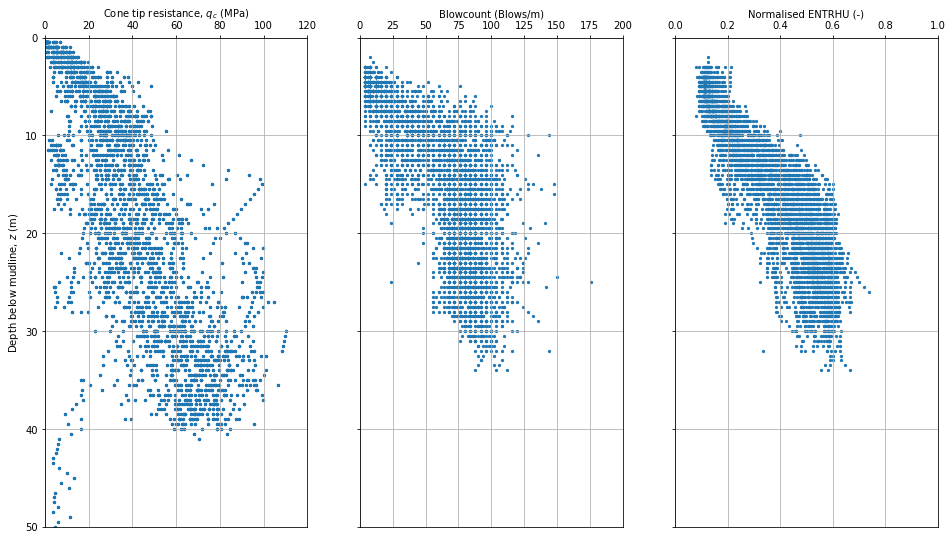

In [5]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,9))
ax1.scatter(data["qc [MPa]"], data["z [m]"], s=5)   # Create the cone tip resistance vs depth plot
ax2.scatter(data["Blowcount [Blows/m]"], data["z [m]"], s=5)  # Create the Blowcount vs depth plot 
ax3.scatter(data["Normalised ENTRHU [-]"], data["z [m]"], s=5) # Create the ENTHRU vs depth plot
# Format the axes (position, labels and ranges)
for ax in (ax1, ax2, ax3):
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.grid()
    ax.set_ylim(50, 0)
ax1.set_xlabel(r"Cone tip resistance, $ q_c $ (MPa)")
ax1.set_xlim(0, 120)
ax2.set_xlabel(r"Blowcount (Blows/m)")
ax2.set_xlim(0, 200)
ax3.set_xlabel(r"Normalised ENTRHU (-)")
ax3.set_xlim(0, 1)
ax1.set_ylabel(r"Depth below mudline, $z$ (m)")
# Show the plot
plt.show()

The cone resistance data shows that the site mainly consists of sand of varying relative density. In certain profiles, clay is present below 10m. There are also locations with very high cone resistance (>70MPa).

The blowcount profile shows that blowcount is relatively well clustered around a generally increasing trend with depth. The normalised ENTHRU energy is also increasing with depth.

We can isolate the data for a single location by selecting this data from the dataframe with all data. As an example, we can do this for location <i>EK</i>.

In [6]:
# Select the data where the column 'Location ID' is equal to the location name
location_data = data[data["Location ID"] == "EK"]

We can plot the data for this location on top of the general data cloud.

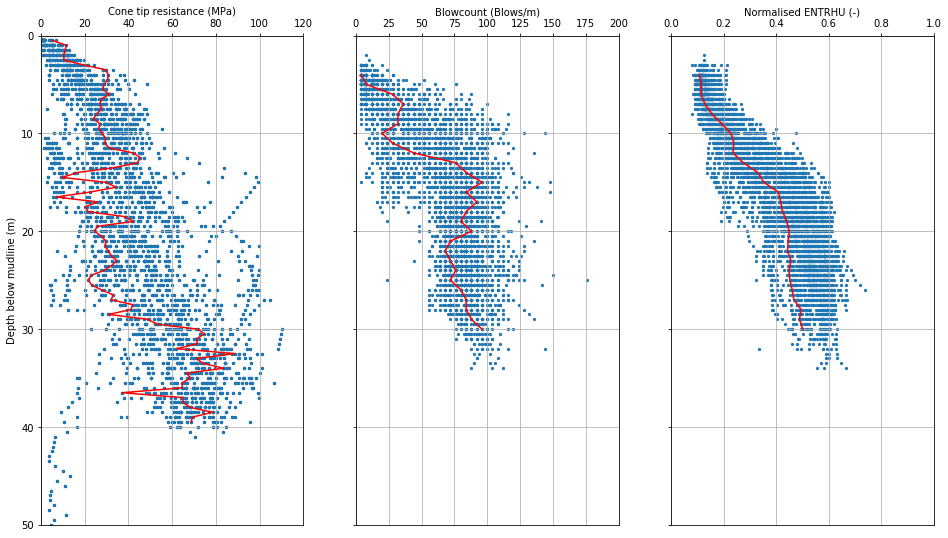

In [7]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True, figsize=(16,9))
# All data
ax1.scatter(data["qc [MPa]"], data["z [m]"], s=5)
ax2.scatter(data["Blowcount [Blows/m]"], data["z [m]"], s=5)
ax3.scatter(data["Normalised ENTRHU [-]"], data["z [m]"], s=5)
# Location-specific data
ax1.plot(location_data["qc [MPa]"], location_data["z [m]"], color='red')
ax2.plot(location_data["Blowcount [Blows/m]"], location_data["z [m]"], color='red')
ax3.plot(location_data["Normalised ENTRHU [-]"], location_data["z [m]"], color='red')
for ax in (ax1, ax2, ax3):
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.grid()
    ax.set_ylim(50, 0)
ax1.set_xlabel(r"Cone tip resistance (MPa)")
ax1.set_xlim(0, 120)
ax2.set_xlabel(r"Blowcount (Blows/m)")
ax2.set_xlim(0, 200)
ax3.set_xlabel(r"Normalised ENTRHU (-)")
ax3.set_xlim(0, 1)
ax1.set_ylabel(r"Depth below mudline (m)")
plt.show()

We can see that pile driving started from 5m depth and continued until a depth of 30m, when the pile tip reached a sand layer with $ q_c $ > 60MPa.

Feel free to investigate the soil profile and driving data for the other locations by changing the location ID.

For the purpose of the prediction event, we are interested in the variation of blowcount with $ q_c $, hammer energy, ... We can also generate plots to see the correlations. The data shows significant scatter and non-linear behaviour. We will take this into account for our machine learning model.

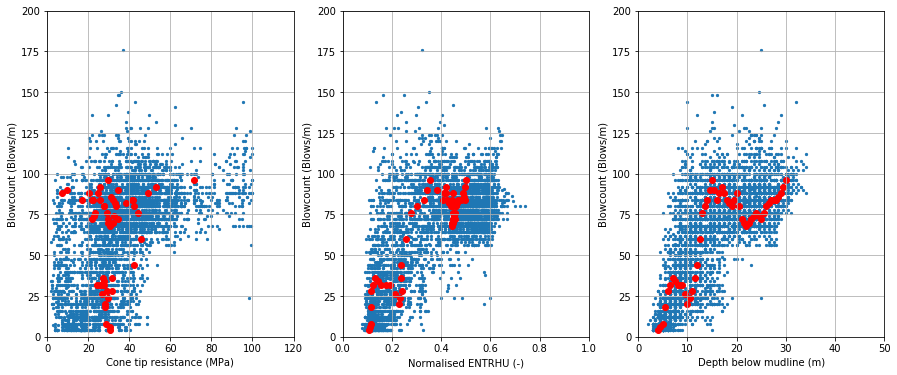

In [8]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
# All data
ax1.scatter(data["qc [MPa]"], data["Blowcount [Blows/m]"], s=5)
ax2.scatter(data["Normalised ENTRHU [-]"], data["Blowcount [Blows/m]"], s=5)
ax3.scatter(data["z [m]"], data["Blowcount [Blows/m]"], s=5)
# Location-specific data
ax1.scatter(location_data["qc [MPa]"], location_data["Blowcount [Blows/m]"], color='red')
ax2.scatter(location_data["Normalised ENTRHU [-]"], location_data["Blowcount [Blows/m]"], color='red')
ax3.scatter(location_data["z [m]"], location_data["Blowcount [Blows/m]"], color='red')
for ax in (ax1, ax2, ax3):
    ax.grid()
    ax.set_ylim(0, 200)
    ax.set_ylabel(r"Blowcount (Blows/m)")
ax1.set_xlabel(r"Cone tip resistance (MPa)")
ax1.set_xlim(0, 120)
ax2.set_xlabel(r"Normalised ENTRHU (-)")
ax2.set_xlim(0, 1)
ax3.set_xlabel(r"Depth below mudline (m)")
ax3.set_xlim(0, 50)
plt.show()

## 3. Basics of machine learning

The goal of the prediction exercise is to define a model relating the input (soil data, hammer energy, pile data) with the output (blowcount).

In ML terminology, we call the inputs (the columns of the dataset except for the blowcount) <i>features</i>. The blowcount is the <i>target variable</i>. Each row in the dataframe represents a <i>sample</i>, a combination of feature values for which the output is known. Data for which a value of the target variable is not yet available is called <i>unseen data</i>.

Before we dive into the code for generating ML models, let's discuss some of the concepts in more detail.

### 3.1. Machine learning techniques

ML combines several data science techniques under one general denominator. We can discern the following families:

   - Classification: Predict the value of a discrete target variable of a data point based on its features
   - Regression: Predict the value of a continuous target variable based on its features
   - Clustering: Identify groups of similar data points based on their features
   - Dimensionality reduction: Identify the features with the greatest influence on the data
   
The first techniques are examples of <i>supervised learning</i>. We will use data where the output has been observed and use that to <i>train</i> the ML model. Training a model is essentially the optimisation of the coefficients of a mathematical model to minimise the difference between model predictions and observed values. Such a trained algorithm is then capable of making predictions for unseen data.

<img src="Images/machine_learning_concept.png">
<br><center><b>Sketch of the machine learning concept</b></center>

This concept is not fundamentally different from any other type of data-driven modelling. The main advantage of the ML approach is the speed at which the models can be trained and the many types of models available to the engineer.

In our example of pile driving, we have a <b>regression</b> problem where we are training a model to relate features (soil data, hammer energy and pile data) with a continuous target variable (blowcount).

### 3.2. Model fitting

Machine learning has disadvantages which can lead to problematic situations if the techniques are misused. One of these disadvantages is that the ML algorithm will always find a fit, even if it is a poor one.

The figure below shows an example with data showing a non-linear trend between input and output with some scatter around a trend. We can identify the following situations:

   - Underfitting: If we use a linear model for this data, we are not capturing the trend. The model predictions will be poor;
   - Good fit: If we formulate a model (quadratic in this case) which captures the general trend but allows variations around the trend, we obtain a good fit. In geotechnical problems, we will never get a perfect a fit but if we identify the influence of the input parameters in a consistent manner, we can build good-quality models;
   - Overfitting: If we have a model which perfectly fits all known data points, the prediction for an unseen data point will be poor. The influence of each measurement on the model is too important. The model overfits the data and does not capture the general trends. It just represents the data on which it was trained.

<img src="Images/over_underfitting.png">
<br><center><b>Underfitting and overfitting</b></center>

### 3.3. Model metrics

To prevent misuse of ML models, we will look at certain model metrics to check the quality. There are several model metrics. Two of the more common ones are the <b>Mean Squared Error (MSE)</b> and the <b>coefficient of determination ($ R^2 $)</b>.

The MSE-value is the normalised sum of quadratic differences. The closer it is to 0, the better the fit.

$$ \text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2. $$

$ \hat{y}_i $ is the predicted value of the i-th sample and $ y_i $ is the true (measured) value.

The coefficient of determination ($ R^2 $) is a measure for a measure of how well future samples are likely to be predicted by the model. A good model has an $ R^2 $-value which is close to 1.

$$ R^2(y, \hat{y}) = 1 - \frac{\sum_{i=0}^{n_{\text{samples}} - 1} (y_i - \hat{y}_i)^2}{\sum_{i=0}^{n_\text{samples} - 1} (y_i - \bar{y})^2} \quad \text{where} \ \bar{y} =  \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}} - 1} y_i$$

In the example, we will see how we can easily calculate these metrics from the data using the functions available in the ML Python package ```scikit-learn```.

### 3.4. Model validation

When building a ML model, we will only use a subset of the data for training the model. The other subset is deliberately excluded from the learning process and used to <i>validate</i> the model. The trained model is applied on the unseen data of the validation dataset and the accuracy of the predictions is checked, resulting in a validation score representing the accuracy of the model for the validation dataset.

If our trained model is of good quality, the predictions for the validation dataset will be close to the measured values.

We will partition our data in a training dataset and a validation dataset. For the validation data set, we use seven piles. The other piles will be used as the training dataset.

In [9]:
validation_ids = ['EL', 'CB', 'AV', 'BV', 'EF', 'DL', 'BM']
# Training data - ID not in validation_ids
training_data = data[~data['Location ID'].isin(validation_ids)]
# Validation data - ID in validation_ids
validation_data = data[data['Location ID'].isin(validation_ids)]

With these concepts in mind, we can start building up a simple ML model.

## 4. Basic machine learning example: Linear modelling

The most basic type of ML model is a linear model. We are already using linear models in a variety of applications and often fit them without making use of ML techniques. The general equation for a linear model is given below for a model with $ N $ features:

$$ y = a_0 + a_1 \cdot x_1 + a_2 \cdot x_2 + ... + a_N \cdot x_N + \epsilon $$

where $ \epsilon $ is the estimation error.

Based on the training dataset, the value of the coefficients ($ a_0, a_1, ..., a_N $) is determined using optimisation techniques to minimise the difference between measured and predicted values. As the equation shows, a good fit will be obtained when the relation between output and inputs is truly linear. If there are non-linearities in the data, the fit will be less good.

We will illustrate how a linear regression machine learning model is generated from the available driving data.

### 4.1. Linear model based on normalised ENTHRU only

The simplest linear model depends on only one feature. We can select the normalised energy transmitted to the pile (ENTRHU) as the only feature for illustration purposes.

The mathematical form of the model can be written as:

$$ BLCT = a_o + a_1 \cdot \text{ENTRHU}_{norm} + \epsilon $$

We will create a dataframe $ X $ with only the normalised ENTHRU feature data and we will put the observed values of the target variable (blowcount) in the vector $ y $.

Note that machine learning algorithms will raise errors when NaN values are provided. We need to ensure that we remove such values. We can creata a dataframe ```cleaned_training_data``` which only contains rows with no NaN values.

In [10]:
features = ['Normalised ENTRHU [-]']
cleaned_training_data = training_data.dropna() # Remove NaN values
X = cleaned_training_data[features]
y = cleaned_training_data["Blowcount [Blows/m]"]

We can now create a linear model. We need to import this type of model from the scikit-learn package. We can fit the linear model to the data using the ```fit()``` method.

In [11]:
from sklearn.linear_model import LinearRegression
model_1 = LinearRegression().fit(X,y)

At this point, our model has been trained with the data and the coefficients are known. $ a_0 $ is called the intercept and $ a_1 $ to $ a_n $ are stored in ```coef_```. Because we only have one feature, ```coef_``` only returns a single value.

In [12]:
model_1.coef_, model_1.intercept_

(array([121.95595131]), 19.694209153892828)

We can plot the data with our trained fit. We can see that the fit follows a general trend but the quality is not great.

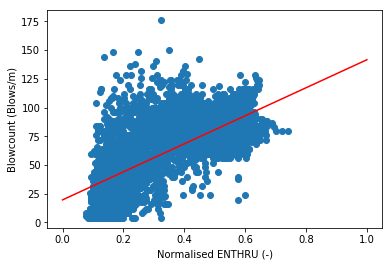

In [13]:
plt.scatter(X, y)
x = np.linspace(0.0, 1, 50)
plt.plot(x, model_1.intercept_ + model_1.coef_ * x, color='red')
plt.xlabel("Normalised ENTHRU (-)")
plt.ylabel("Blowcount (Blows/m)")
plt.show()

We can also calculate the $ R^2 $ score for our training data. The score is below 0.5 and it goes without saying that this model needs improvement.

In [14]:
model_1.score(X,y)

0.46415658013693784

In the following sections, we will explore ways to improve our model.

### 4.2. Linearizing features

When using ENTRHU as our model feature, we can see that a linear model is not the most appropriate choice as the relation between blowcount and ENTRHU is clearly non-linear. However, we can <i>linearize</i> features.

For example, we can propose a relation using using a tangent hyperbolic law, which seems to fit better with the data.

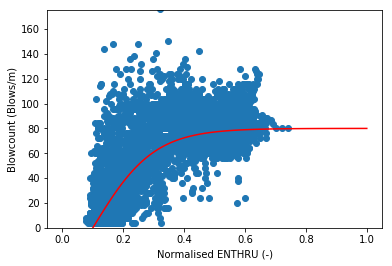

In [15]:
plt.scatter(training_data["Normalised ENTRHU [-]"], training_data["Blowcount [Blows/m]"])
x = np.linspace(0, 1, 100)
plt.plot(x, 80 * np.tanh(5 * x - 0.5), color='red')
plt.xlabel("Normalised ENTHRU (-)")
plt.ylabel("Blowcount (Blows/m)")
plt.ylim([0.0, 175.0])
plt.show()

We can create a linearized feature:

$$ (\text{ENTHRU})_{lin} = \tanh(5 \cdot \text{ENTHRU}_{norm} - 0.5) $$

In [16]:
Xlin = np.tanh(5 * cleaned_training_data[["Normalised ENTRHU [-]"]] - 0.5)

When plotting the linearized data against the blowcount, we can see that a linear relation is much more appropriate.

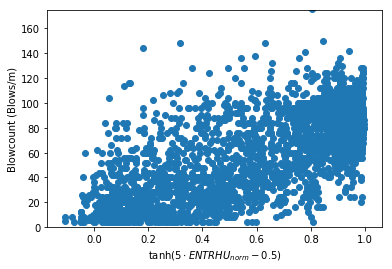

In [17]:
plt.scatter(Xlin, y)
plt.xlabel(r"$ \tanh(5 \cdot ENTRHU_{norm} - 0.5) $")
plt.ylabel("Blowcount (Blows/m)")
plt.ylim([0.0, 175.0])
plt.show()

We can fit another linear model using this linearized feature.

In [18]:
model_2 = LinearRegression().fit(Xlin, y)

We can check the intercept and the model coefficient:

In [19]:
model_2.coef_, model_2.intercept_

(array([69.81939984]), 14.744456831819171)

The model with the linearized feature can then be written as:

$$ BLCT = a_0 + a_1 \cdot (\text{ENTHRU})_{lin} $$ 

We can visualize the fit.

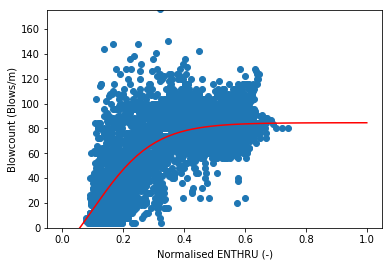

In [20]:
plt.scatter(X, y)
x = np.linspace(0.0, 1, 50)
plt.plot(x, model_2.intercept_ + model_2.coef_ * (np.tanh(5*x - 0.5)), color='red')
plt.xlabel("Normalised ENTHRU (-)")
plt.ylabel("Blowcount (Blows/m)")
plt.ylim([0.0, 175])
plt.show()

We can check the $ R^2 $ model score. By linearizing the normalised ENTHRU energy, we have improved our $ R^2 $ score and are thus fitting a model which better describes our data.

In [21]:
model_2.score(Xlin, y)

0.5536524756394534

### 4.3. Using engineering knowledge

We know from engineering considerations on the pile driving problem that the soil resistance to driving (SRD) can be expressed as the sum of shaft friction and end bearing resistance. The shaft friction can be expressed as the integral of the unit shaft friction over the pile circumference and length.

If we make the simplifying assumption that there is a proportionality between the cone resistance and the unit shaft friction ($ f_s = \alpha \cdot q_c $), we can write the shaft resistance as follows:

$$ R_s = \int_{0}^{L} \alpha \cdot q_c \cdot \pi \cdot D \cdot dz \approx \alpha \cdot \pi \cdot D \cdot \sum q_{c,i} \cdot \Delta z $$

We can create an additional feature for this. Creating features based on our engineering knowledge will often help us to introduce experience in a machine learning algorithm.

To achieve this, we will create a new dataframe using our training data. We will iteration over all locations in the training data and calculate the $ R_s $ feature using a cumulative sum function. We will then put this data together for all locations.

In [22]:
enhanced_data = pd.DataFrame() # Create a dataframe for the data enhanced with the shaft friction feature
for location in training_data['Location ID'].unique(): # Loop over all unique locations
    locationdata = training_data[training_data['Location ID']==location].copy() # Select the location-specific data
    # Calculate the shaft resistance feature
    locationdata["Rs [kN]"] = \
        (np.pi * locationdata["Diameter [m]"] * locationdata["z [m]"].diff() * locationdata["qc [MPa]"]).cumsum()
    enhanced_data = pd.concat([enhanced_data, locationdata]) # Combine data for the different locations in 1 dataframe

We can plot the data to see that the clustering of our SRD shaft resistance feature vs blowcount is much better than the clustering of $ q_c $ vs blowcount. We can also linearize the relation between shaft resistance and blowcount.

We can propose the following relation:

$$ BLCT = 85 \cdot \tanh \left( \frac{R_s}{1000} - 1 \right) $$

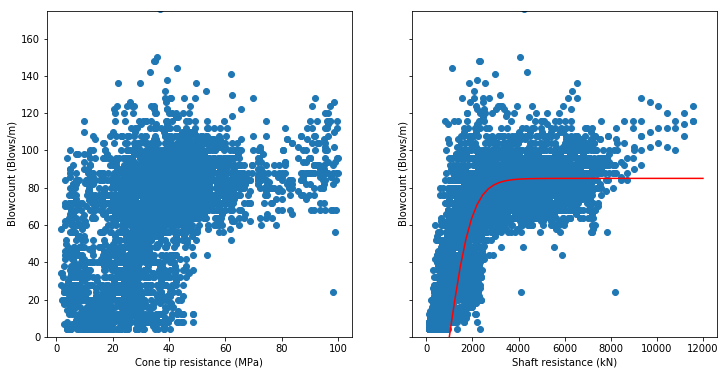

In [23]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
ax1.scatter(enhanced_data["qc [MPa]"], enhanced_data["Blowcount [Blows/m]"])
ax2.scatter(enhanced_data["Rs [kN]"], enhanced_data["Blowcount [Blows/m]"])
x = np.linspace(0.0, 12000, 50)
ax2.plot(x, 85 * (np.tanh(0.001*x-1)), color='red')
ax1.set_xlabel("Cone tip resistance (MPa)")
ax2.set_xlabel("Shaft resistance (kN)")
ax1.set_ylabel("Blowcount (Blows/m)")
ax2.set_ylabel("Blowcount (Blows/m)")
ax1.set_ylim([0.0, 175])
plt.show()

We then proceed to filter the NaN values from the data and fit a linear model.

In [24]:
features = ["Rs [kN]"]
X = enhanced_data.dropna()[features]
y = enhanced_data.dropna()["Blowcount [Blows/m]"]
Xlin = np.tanh((0.001 * X) - 1)

In [25]:
model_3 = LinearRegression().fit(Xlin, y)

We can print the coefficients of the linear model and visualise the fit.

In [26]:
model_3.intercept_, model_3.coef_

(36.72043195452285, array([44.5766327]))

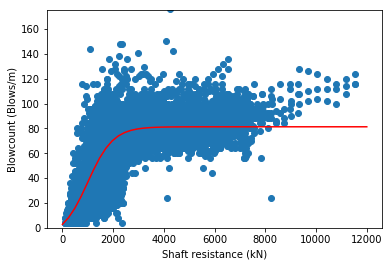

In [27]:
plt.scatter(X, y)
x = np.linspace(0.0, 12000, 50)
plt.plot(x, model_3.intercept_ + model_3.coef_ * (np.tanh(0.001*x - 1)), color='red')
plt.xlabel("Shaft resistance (kN)")
plt.ylabel("Blowcount (Blows/m)")
plt.ylim([0.0, 175])
plt.show()

The fit looks reasonable and this is also reflected in the $ R^2 $ score which is just greater than 0.6. We have shown that using engineering knowledge can greatly improve model quality.

In [28]:
model_3.score(Xlin, y)

0.6039306763425603

### 4.4. Using multiple features

The power of machine learning algorithms is that you can experiment with adding multiple features. Adding a feature can improve you model if it has a meaningful relation with the output.

We can use our linearized relation with normalised ENTHRU, shaft resistance and we can also linearize the variation of blowcount with depth:

$$ BLCT = 100 \cdot \tanh \left( \frac{z}{10} - 0.5 \right) $$

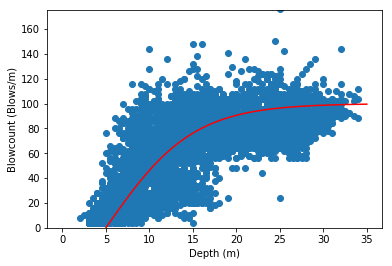

In [29]:
plt.scatter(data["z [m]"], data["Blowcount [Blows/m]"])
z = np.linspace(0,35,100)
plt.plot(z, 100 * np.tanh(0.1 * z - 0.5), color='red')
plt.ylim([0, 175])
plt.xlabel("Depth (m)")
plt.ylabel("Blowcount (Blows/m)")
plt.show()

Our model with the combined features will take the following mathematical form:

$$ BLCT = a_0 + a_1 \cdot \tanh \left( 5 \cdot \text{ENTHRU}_{norm} - 0.5 \right) + a_2 \cdot \tanh \left( \frac{R_s}{1000} - 1 \right) + a_3 \cdot \tanh \left( \frac{z}{10} - 0.5 \right) $$

We can create the necessary features in our dataframe:

In [30]:
enhanced_data["linearized ENTHRU"] = np.tanh(5 * enhanced_data["Normalised ENTRHU [-]"] - 0.5)
enhanced_data["linearized Rs"] = np.tanh(0.001 * enhanced_data["Rs [kN]"] - 1)
enhanced_data["linearized z"] = np.tanh(0.1 * enhanced_data["z [m]"] - 0.5)
linearized_features = ["linearized ENTHRU", "linearized Rs", "linearized z"]

We can now fit a linear model with three features. The matrix $ X $ is now an $ n \times 3 $ matrix ($ n $ samples and 3 features).

In [31]:
X = enhanced_data.dropna()[linearized_features]
y = enhanced_data.dropna()["Blowcount [Blows/m]"]
model_4 = LinearRegression().fit(X,y)

We can calculate the $ R^2 $ score. The score is slightly better compared to our previous model. Given the scatter in the data, this score is already a reasonable value.

In [32]:
model_4.score(X, y)

0.6226585770981693

### 4.4. Model predictions

The linear regression model always allows us to write down the mathematical form of the model. We can do so here by filling in the intercept ($ a_0 $) a coefficients $ a_1 $, $ a_2 $ and $ a_3 $ in the equation above.

In [33]:
model_4.intercept_, model_4.coef_

(24.574230770198668, array([ 2.61421619, 19.8869918 , 39.17286467]))

However, we don't need to explicitly write down the mathematical shape of the model to use it in the code. We can make predictions using the fitted model straightaway.

In [34]:
predictions = model_4.predict(X)
predictions

array([11.30428523, 15.22514248, 19.21447274, ..., 84.47966048,
       84.63940626, 84.78400572])

We can plot these predictions together with the data. We can see that the model follows the general trend of the data fairly well. There is still significant scatter around the trend.

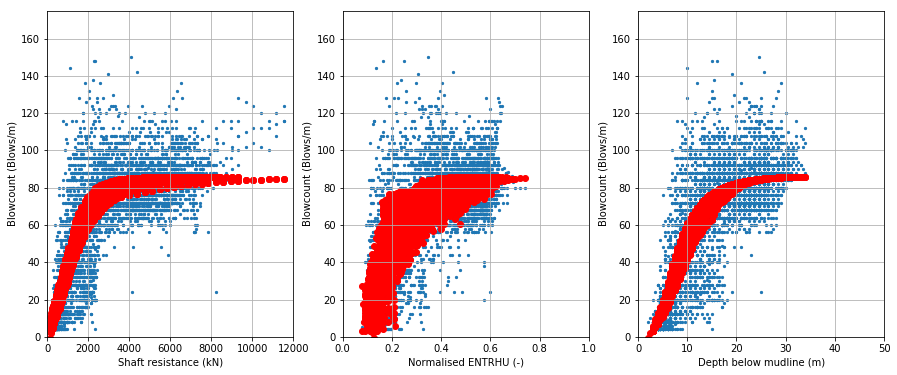

In [35]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
# Measurements
ax1.scatter(enhanced_data["Rs [kN]"], enhanced_data["Blowcount [Blows/m]"], s=5)
ax2.scatter(enhanced_data["Normalised ENTRHU [-]"], enhanced_data["Blowcount [Blows/m]"], s=5)
ax3.scatter(enhanced_data["z [m]"], enhanced_data["Blowcount [Blows/m]"], s=5)
# Predictions
ax1.scatter(enhanced_data.dropna()["Rs [kN]"], predictions, color='red')
ax2.scatter(enhanced_data.dropna()["Normalised ENTRHU [-]"], predictions, color='red')
ax3.scatter(enhanced_data.dropna()["z [m]"], predictions, color='red')
for ax in (ax1, ax2, ax3):
    ax.grid()
    ax.set_ylim(0, 175)
    ax.set_ylabel(r"Blowcount (Blows/m)")
ax1.set_xlabel(r"Shaft resistance (kN)")
ax1.set_xlim(0, 12000)
ax2.set_xlabel(r"Normalised ENTRHU (-)")
ax2.set_xlim(0, 1)
ax3.set_xlabel(r"Depth below mudline (m)")
ax3.set_xlim(0, 50)
plt.show()

During the prediction event, the goal is to fit a machine learning model which further refines the model developed above.

### 4.5 Model validation

At the start of the exercise, we excluded a couple of locations from the fitting to check how well the model would perform for these unseen locations.

We can now perform this validation exercise by calculating the shaft resistance and linearizing the model features. We can then make predictions with our model developed above.

We will illustrate this for location CB.

In [36]:
# Create a copy of the dataframe with location-specific data
validation_data_CB = validation_data[validation_data["Location ID"] == "CB"].copy()

In [37]:
# Calculate the shaft resistance feature and put it in the column 'Rs [kN]'
validation_data_CB["Rs [kN]"] = \
    (np.pi * validation_data_CB["Diameter [m]"] * \
     validation_data_CB["z [m]"].diff() * validation_data_CB["qc [MPa]"]).cumsum()

In [38]:
# Calculate linearized ENTHRU, Rs and z
validation_data_CB["linearized ENTHRU"] = np.tanh(5 * validation_data_CB["Normalised ENTRHU [-]"] - 0.5)
validation_data_CB["linearized Rs"] = np.tanh(0.001 * validation_data_CB["Rs [kN]"] - 1)
validation_data_CB["linearized z"] = np.tanh(0.1 * validation_data_CB["z [m]"] - 0.5)

In [39]:
# Create the matrix with n samples and 3 features
X_validation = validation_data_CB.dropna()[linearized_features]
# Create the vector with n observations of blowcount
y_validation = validation_data_CB.dropna()["Blowcount [Blows/m]"]

Given our fitted model, we can now calculate the $ R^2 $ score for our validation data. The score is relatively high and we can conclude that the model generalises well. If this validation score would be low, we would have to re-evaluate our feature selection.

In [40]:
# Calculate the R2 score for the validation data
model_4.score(X_validation, y_validation)

0.7595697386847182

We can calculate the predicted blowcounts for our validation data.

In [41]:
validation_predictions = model_4.predict(X_validation)

The predictions (red dots) can be plotted against the actual observed blowcounts. The cone resistance and normalised ENTRHU are also plotted for information.

The predictions are reasonable and follow the general trend fairly well. In the layer with lower cone resistance below (10-15m depth), there is an overprediction of blowcount. This is due to the relatively limited amount of datapoints with low cone resistance in the training data. Further model refinement could address this issue. 

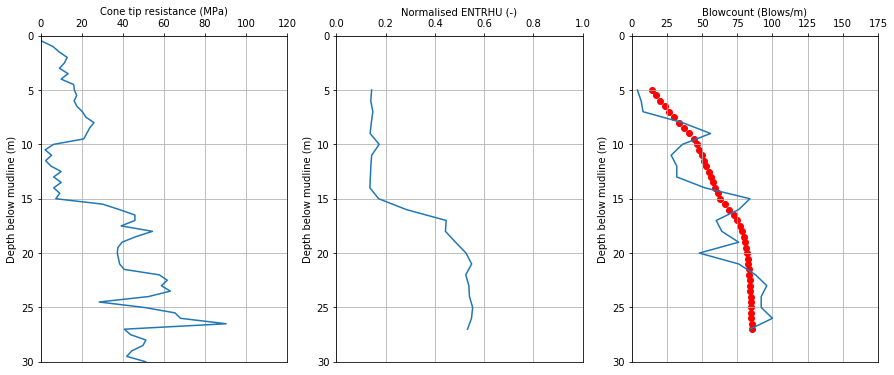

In [42]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
# All data
ax1.plot(validation_data_CB["qc [MPa]"], validation_data_CB["z [m]"])
ax2.plot(validation_data_CB["Normalised ENTRHU [-]"], validation_data_CB["z [m]"])
ax3.plot(validation_data_CB["Blowcount [Blows/m]"], validation_data_CB["z [m]"])
# Location-specific data
ax3.scatter(validation_predictions, validation_data_CB.dropna()["z [m]"], color='red')
for ax in (ax1, ax2, ax3):
    ax.grid()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_ylim(30, 0)
    ax.set_ylabel(r"Depth below mudline (m)")
ax1.set_xlabel(r"Cone tip resistance (MPa)")
ax1.set_xlim(0, 120)
ax2.set_xlabel(r"Normalised ENTRHU (-)")
ax2.set_xlim(0, 1)
ax3.set_xlabel(r"Blowcount (Blows/m)")
ax3.set_xlim(0, 175)
plt.show()

The process of validation can be automated. The [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html) has further details on this.

## 5. Prediction event submission

While a number of locations are held out during the training process to check if the model generalises well, the model will have to be applied to unseen data and predictions will need to be submitted.

The validation data which will be used for the ranking of submissions is provided in the file ```validation_data.csv```.

In [43]:
final_data = pd.read_csv("Data/validation_data.csv")
final_data.head()

,z [m],qc [MPa],fs [MPa],u2 [MPa],ID,Location ID,Normalised ENTRHU [-],Normalised hammer energy [-],Diameter [m],Bottom wall thickness [mm],Pile penetration [m]
0,0.5,0.8697,0.0075,0.0041,BJ__0_5,BJ,NaN,NaN,2.48,70.0,25.0
1,1.0,3.9027,0.0499,0.0151,BJ__1_0,BJ,NaN,NaN,2.48,70.0,25.0
2,1.5,10.2930,0.0718,0.0115,BJ__1_5,BJ,NaN,NaN,2.48,70.0,25.0
3,2.0,14.3678,0.1428,0.0246,BJ__2_0,BJ,NaN,NaN,2.48,70.0,25.0
4,2.5,16.0034,0.1474,0.0338,BJ__2_5,BJ,NaN,NaN,2.48,70.0,25.0


We can see that the target variable (```Blowcount [Blows/m]```) is not provided and we need to predict it.

Similary to the previous process, we will calculate the shaft resistance to enhance our data.

In [44]:
enhanced_final_data = pd.DataFrame() # Create a dataframe for the final data enhanced with the shaft friction feature
for location in final_data['Location ID'].unique(): # Loop over all unique locations
    locationdata = final_data[final_data['Location ID']==location].copy() # Select the location-specific data
    # Calculate the shaft resistance feature
    locationdata["Rs [kN]"] = \
        (np.pi * locationdata["Diameter [m]"] * locationdata["z [m]"].diff() * locationdata["qc [MPa]"]).cumsum()
    enhanced_final_data = pd.concat(
        [enhanced_final_data, locationdata]) # Combine data for the different locations in 1 dataframe

A NaN value is generated at the pile top, we can remove any NaN values using the ```dropna``` method on the DataFrame.

In [45]:
enhanced_final_data.dropna(inplace=True) # Drop the rows containing NaN values and overwrite the dataframe

We can then linearize the features as before:

In [46]:
enhanced_final_data["linearized ENTHRU"] = np.tanh(5 * enhanced_final_data["Normalised ENTRHU [-]"] - 0.5)
enhanced_final_data["linearized Rs"] = np.tanh(0.001 * enhanced_final_data["Rs [kN]"] - 1)
enhanced_final_data["linearized z"] = np.tanh(0.1 * enhanced_final_data["z [m]"] - 0.5)

We can extract the linearized features which are required for the predictions:

In [47]:
# Create the matrix with n samples and 3 features
X = enhanced_final_data[linearized_features]

We can make the predictions using our final model:

In [48]:
final_predictions = model_4.predict(X)

We can assign these predictions to the column ```Blowcount [Blows/m]``` in our resulting dataframe.

In [49]:
enhanced_final_data["Blowcount [Blows/m]"] = final_predictions

We can write this file to a csv in the ```Output``` folder.

In [50]:
enhanced_final_data.to_csv("Output/predictions.csv", index=False)

For the submission, we only need the ```ID``` and ```Blowcount [Blows/m]``` column. 

In [51]:
enhanced_final_data[["ID", "Blowcount [Blows/m]"]].to_csv("Output/sample_submission.csv", index=False)

## 6. Conclusions

This tutorial shows how a basic machine learning model can be built up. The workflow shows the importance of integrating engineering knowledge and to ensure that the models make physical sense.

A machine learning workflow is not fundamentally different from a conventional workflow for fitting a semi-empirical model. The methods available in scikit-learn make the process scaleable to large datasets with only a few lines of code.

The workflow will always consist of the following steps:

   - Select features for the machine learning. Use engineering knowledge to construct features which have a better correlation with the target variable under consideration;
   - Split the dataset in a training dataset and a validation dataset;
   - Select the type of machine learning model you want to use (e.g. Linear regression, Support Vector Machines, Neural Nets, ...);
   - Train the model using the training data;
   - Validate the model on the validation data;

If the validation is successful, the model can be used for predictions on unseen data. These predictions can then be submitted as an entry in the competition.

## 7. Can you do better?

This tutorial shows the creation of a simple linear model. This is only one possible model from the [many possible regression models available in scikit-learn](https://scikit-learn.org/stable/supervised_learning.html).

After getting familiar with the basic concepts, participants are invited to suggest improved blowcount prediction models.

## 8. Further reading

The internet has a large amount of information available on machine learning. Here are a couple of suggestions to guide your reading:

   - [scikit-learn documentation](https://scikit-learn.org/stable/tutorial/basic/tutorial.html): The scikit-learn package has extensive documentation and provides good general-purpose tutorials;
   - [10 minutes to Pandas](http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html): The Pandas package is used extensively in this tutorial to facilitate the data processing. Getting to grips with Pandas is a good idea for every aspiring data enthousiast. The Pandas documentation is extensive and this guide provides you with a good overview of the capabilities of the package;
   - [Towards data science](https://towardsdatascience.com/): A blog with frequent posts on data science topics with contributions for the novice and advanced data scientist. 